In [1]:
# Libraries

import argparse
import os
import platform
import itertools
import ray
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tuner

ray.init(include_dashboard = False)

from ray.tune import choice
from ray.tune import uniform
from ray.tune import loguniform
from ray.tune import randint
from ray.tune import grid_search

2023-05-28 09:18:14,473	INFO worker.py:1538 -- Started a local Ray instance.


In [4]:
# Code

from source.python.raytune import raytune_data
from source.python.raytune import raytune_model
from source.python.raytune import raytune_plot
from source.python.raytune import raytune_utils
from source.python.raytune import raytune_feature
from source.python.io      import loader
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [5]:
# Define output and inputs

TUNER_CONCURRENT = 1
TUNER_TRIALS     = 5
TUNER_GRACE      = 5
TUNER_NOTEBOOK   = True
TUNER_SEARCH     = 'gridsearch'
MODEL_EPOCHS     = 10
GENERATOR        = 'group'

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)

	_split_generators = ['stratified', 'group', 'random']

	parser.add_argument('--tuner_concurrent', type = int, default = 5)
	parser.add_argument('--tuner_trials',     type = int, default = 500)
	parser.add_argument('--tuner_grace',      type = int, default = 10)
	parser.add_argument('--model_epochs',     type = int, default = 50)
	parser.add_argument('--generator',        type = str, default = 'group', choices = _split_generators)

	args = vars(parser.parse_args())

	TUNER_CONCURRENT = args['tuner_concurrent']
	TUNER_TRIALS     = args['tuner_trials']
	TUNER_GRACE      = args['tuner_grace']
	MODEL_EPOCHS     = args['model_epochs']
	GENERATOR        = args['generator']

	TUNER_NOTEBOOK   = False

Running as .ipynb


In [7]:
# Setup some directory paths.

SUBFOLDER = os.path.join('nbp06-tuner', 'feature')

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      SUBFOLDER)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\feature
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\feature\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner


In [8]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 16.749 GB


# 2. Tuner

In [9]:
# Define basic data parameters

CONFIG = {
	'core/device'             : DEVICE,
	'core/outdir'             : OUT_DATA,
	'core/random'             : None,
	'core/rootdir'            : ROOT,
	'core/subfolder'          : SUBFOLDER,
	'dataset/expanddim'       : None,
	'dataset/split/generator' : GENERATOR,
	'dataset/split/test'      : 0.2,
	'dataset/split/valid'     : 0.2,
	'model/epochs'            : MODEL_EPOCHS,
	'model/input/features'    : 72,
	'model/mode'              : 'regression',
	'model/output/size'       : 1,
	'model/type'              : 'r',
	'params/filepath'         : RES_TUNER,
	'params/tuner'            : None,
	'plot/trials'             : 3,
	'tuner/checkpoint'        : False,
	'tuner/max_concurrent'    : TUNER_CONCURRENT,
	'tuner/max_epochs'        : MODEL_EPOCHS,
	'tuner/min_epochs'        : TUNER_GRACE,
	'tuner/reporter/freq'     : 30,
	'tuner/reporter/notebook' : TUNER_NOTEBOOK,
	'tuner/search'            : 'gridsearch',
	'tuner/stopper'           : True,
	'tuner/stopper/days'      : 3,
	'tuner/stopper/hours'     : 22,
	'tuner/stopper/minutes'   : 0,
	'tuner/trials'            : TUNER_TRIALS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

# 3. Search Space

In [10]:
# Define optimizer parameters

optimizer_lr       = loguniform(1e-7, 1e-3)
optimizer_decay    = uniform(0.000, 0.100)
optimizer_beta1    = uniform(0.500, 0.950)
optimizer_beta2    = uniform(0.951, 0.999)

In [11]:
# Define scheduler parameters

scheduler_name             = choice(['exponential'])
scheduler_plateau_factor   = uniform(0.1, 0.5)
scheduler_plateau_patience = randint(5, 25)
scheduler_linear_factor    = uniform(1e-07, 2e-01)
scheduler_exp_factor       = uniform(0.900, 0.999)

In [12]:
# Define model parameters

model_dropout   = uniform(0.0, 0.5)
model_leakyrelu = uniform(0.0, 0.1)

fc1_features = [64, 128, 256, 512]
fc2_features = [64, 128, 256, 512]

In [13]:
# Grid Search

gs_model = [
	'densefc2',
	'densefc3'
]

gs_filter = [
	'filter1', #          all -          longest transcript per gene
	'filter2', #          all - maximum mean tpm transcript per gene
	'filter3', #          tpm - average tpm > 5
	'filter4', # perturbation - control + unstressed
	'filter5'  #       strand - positive
]

gs_target = [
	'global-mean'
]

In [14]:
# Define search space

param_space = dict()

# Dataset
param_space['dataset/batch_size'] = choice([32, 64, 128])

# Optimizer
param_space['optimizer/name']  = 'adam'
param_space['optimizer/lr']    = optimizer_lr
param_space['optimizer/decay'] = optimizer_decay
param_space['optimizer/beta1'] = optimizer_beta1
param_space['optimizer/beta2'] = optimizer_beta2

# Criterion
param_space['criterion/name']      = 'mse'
param_space['criterion/reduction'] = 'mean'

# Scheduler
param_space['scheduler/name']               = scheduler_name
param_space['scheduler/plateau/factor']     = scheduler_plateau_factor
param_space['scheduler/plateau/patience']   = scheduler_plateau_patience
param_space['scheduler/linear/factor']      = scheduler_linear_factor
param_space['scheduler/exponential/factor'] = scheduler_exp_factor

# Model
param_space['model/dropout']   = model_dropout
param_space['model/leakyrelu'] = model_leakyrelu

# Linear
param_space['model/fc1/features'] = choice(fc1_features)
param_space['model/fc2/features'] = choice(fc2_features)

# Grid Search
param_space['gs/model']   = grid_search(gs_model)
param_space['gs/filter']  = grid_search(gs_filter)
param_space['gs/target']  = grid_search(gs_target)

# 4. Tuning

In [15]:
# Create tuner config

trainable = raytune_utils.create_trainable(
	method    = raytune_feature.main,
	config    = CONFIG,
	cpu_count = SYSTEM['platform/cpu/count'],
	gpu_count = SYSTEM['platform/gpu/count']
)

tune_config = raytune_utils.create_tune_config(
	config    = CONFIG,
	algorithm = CONFIG['tuner/search'],
	params    = None
)

run_config = raytune_utils.create_run_config(
	config    = CONFIG,
	local_dir = OUT_DATA,
	verbosity = raytune_utils.VERBOSE_STATUS,
	task      = 'feature'
)

In [16]:
# Create tune and fit

tuner = raytune_utils.create_tuner(
	trainable   = trainable,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-05-28 09:48:31,654	INFO tune.py:762 -- Total run time: 1811.13 seconds (1810.88 seconds for the tuning loop).


# 5. Reports

In [17]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [18]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

print()

valid_loss                               valid_r2                                 valid_mae                                
valid_mape                               valid_wmape                              train_loss                               
train_r2                                 train_mae                                train_mape                               
train_wmape                              lr                                       time_this_iter_s                         
done                                     timesteps_total                          episodes_total                           
training_iteration                       trial_id                                 experiment_id                            
date                                     timestamp                                time_total_s                             
pid                                      hostname                                 node_ip                                  
time_sin

In [19]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

if CONFIG['model/mode'] == 'regression' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1'
	]]

trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :      0.2 minutes
 Longest training time :      0.7 minutes
   Total training time :     25.2 minutes
    Mean training time :      0.5 minutes



,trial_id,logdir,time_total_s,training_iteration,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
27,96960_00027,C:\Developer\Workspace\PyCharm\Projects\upolan...,28.699,10,0.433,0.044,0.522,0.344,0.235,0.404,0.092,0.502,0.310,0.226
22,96960_00022,C:\Developer\Workspace\PyCharm\Projects\upolan...,29.460,10,0.425,0.065,0.514,0.344,0.232,0.405,0.090,0.501,0.312,0.225
26,96960_00026,C:\Developer\Workspace\PyCharm\Projects\upolan...,41.333,10,0.744,0.122,0.706,1.888,0.394,0.718,0.147,0.696,1.738,0.391
28,96960_00028,C:\Developer\Workspace\PyCharm\Projects\upolan...,42.875,10,0.752,0.120,0.710,1.784,0.395,0.726,0.145,0.700,1.657,0.392
29,96960_00029,C:\Developer\Workspace\PyCharm\Projects\upolan...,20.292,10,0.754,0.101,0.714,1.828,0.397,0.744,0.113,0.697,2.058,0.391
21,96960_00021,C:\Developer\Workspace\PyCharm\Projects\upolan...,42.020,10,0.748,0.117,0.710,1.906,0.396,0.745,0.121,0.714,1.679,0.403
23,96960_00023,C:\Developer\Workspace\PyCharm\Projects\upolan...,42.493,10,0.756,0.116,0.714,1.800,0.397,0.753,0.119,0.718,1.601,0.404
24,96960_00024,C:\Developer\Workspace\PyCharm\Projects\upolan...,20.477,10,0.758,0.094,0.716,1.841,0.398,0.756,0.114,0.708,2.072,0.398
25,96960_00025,C:\Developer\Workspace\PyCharm\Projects\upolan...,40.458,10,0.763,0.110,0.726,1.867,0.424,0.777,0.100,0.729,2.134,0.427
20,96960_00020,C:\Developer\Workspace\PyCharm\Projects\upolan...,36.187,10,0.770,0.100,0.732,1.907,0.427,0.778,0.104,0.735,2.002,0.430


In [20]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, 'report.csv')
)

## 5.1 Visualization

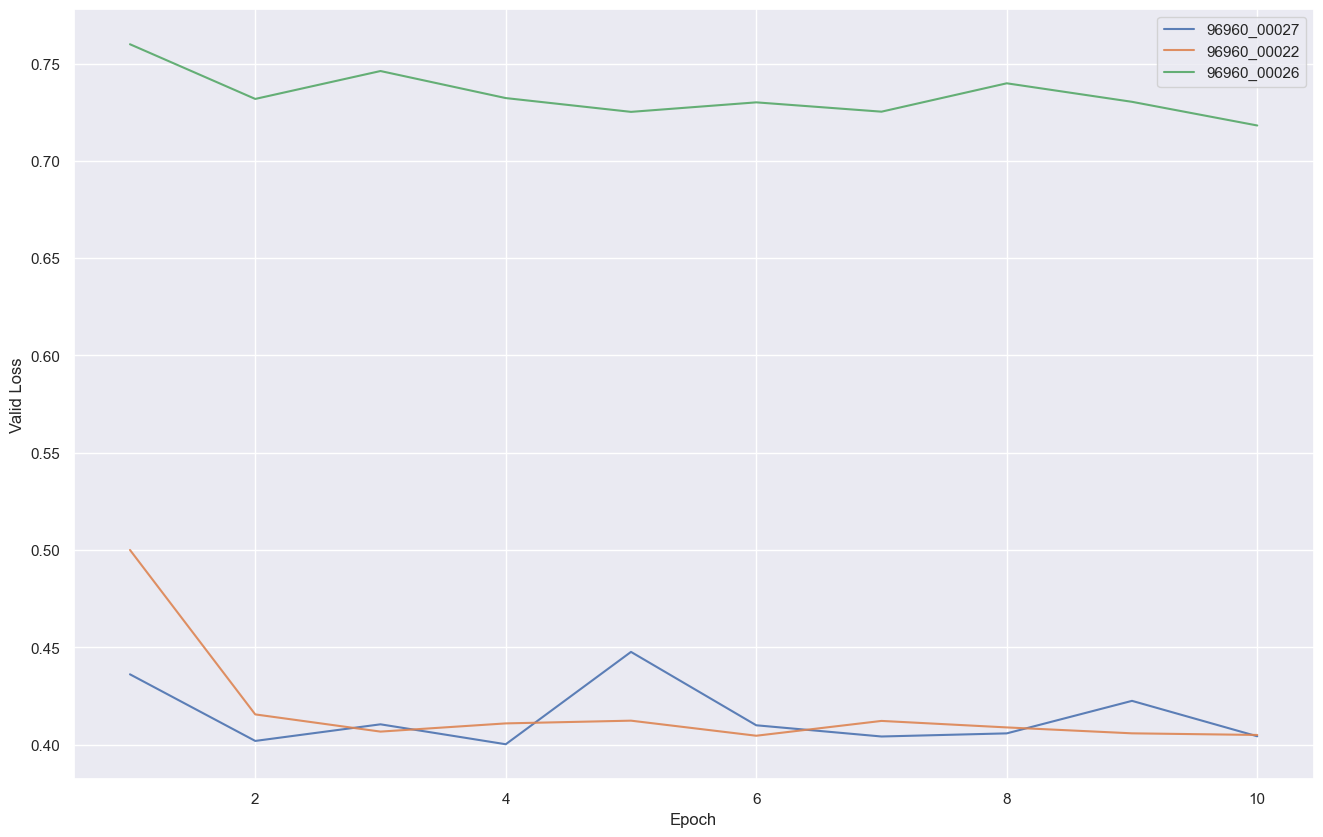

In [21]:
# Plot trials valid loss

raytune_plot.trials_lineplot_loss(
	dataframe  = trials,
	max_trials = CONFIG['plot/trials'],
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

### 5.1.1 Regression

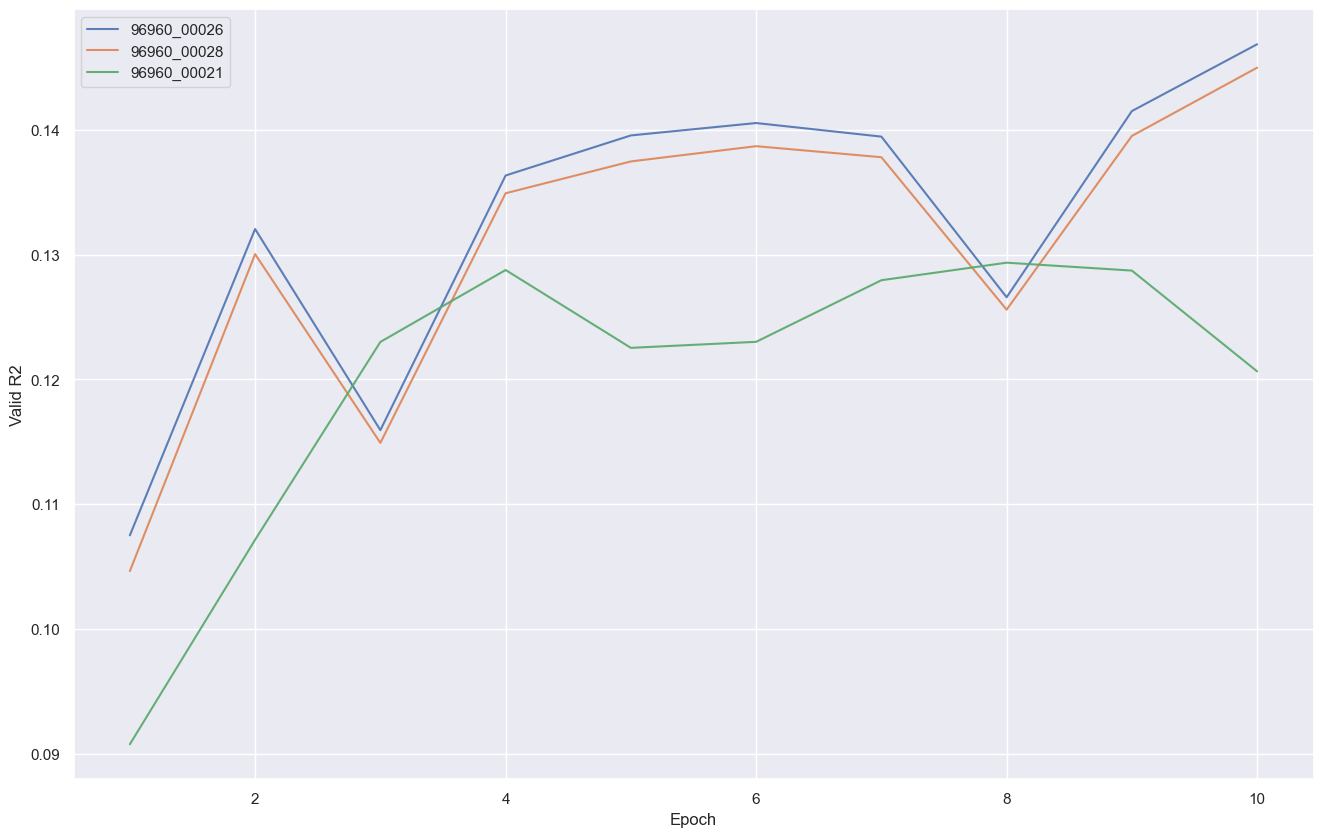

In [22]:
# Plot trials valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_lineplot_r2(
		dataframe  = trials,
		max_trials = CONFIG['plot/trials'],
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

### 5.1.2 Classification

In [23]:
# Plot trials valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_lineplot_accuracy(
		dataframe  = trials,
		max_trials = CONFIG['plot/trials'],
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

## 5.2 Best

In [24]:
# Display best trial

best = report.get_best_result()

if CONFIG['model/mode'] == 'regression'     : metrics = ['loss', 'r2', 'mae', 'mape', 'wmape']
if CONFIG['model/mode'] == 'classification' : metrics = ['loss', 'accuracy', 'auroc', 'f1', 'matthews']

for mode, metric in itertools.product(['train', 'valid'], metrics) :
	k0 = 'metrics/{}/{}'.format(mode, metric)
	k1 = '{}_{}'.format(mode, metric)

	best.config[k0] = float(best.metrics[k1])

print('Best config :')
print()
print('{')

for index, (key, val) in enumerate(sorted(best.config.items()), start = 1) :
	if isinstance(key, str)   : key = f'"{key}"'
	if isinstance(val, str)   : val = f'"{val}"'

	if isinstance(val, float) : print('\t{:30s} : {:.16f}'.format(key, val), end = '')
	else                      : print('\t{:30s} : {}'.format(key, val), end = '')

	if index < len(best.config) : print(',')
	else                        : print('')

print('}')

Best config :

{
	"criterion/name"               : "mse",
	"criterion/reduction"          : "mean",
	"dataset/batch_size"           : 128,
	"gs/filter"                    : "filter3",
	"gs/model"                     : "densefc3",
	"gs/target"                    : "global-mean",
	"metrics/train/loss"           : 0.4334832809491840,
	"metrics/train/mae"            : 0.5215383408404237,
	"metrics/train/mape"           : 0.3440250158309937,
	"metrics/train/r2"             : 0.0443991236388683,
	"metrics/train/wmape"          : 0.2352871894836426,
	"metrics/valid/loss"           : 0.4042970240634148,
	"metrics/valid/mae"            : 0.5024010157773779,
	"metrics/valid/mape"           : 0.3097088038921356,
	"metrics/valid/r2"             : 0.0918281599879265,
	"metrics/valid/wmape"          : 0.2259960174560547,
	"model/dropout"                : 0.1120660770415596,
	"model/fc1/features"           : 256,
	"model/fc2/features"           : 256,
	"model/leakyrelu"              : 0.0601512275750

In [25]:
# Display per iteration

progress = loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

if CONFIG['model/mode'] == 'regression' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1', 'train_matthews',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1', 'valid_matthews'
	]]

progress

,trial_id,time_total_s,training_iteration,lr,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
0,96960_00027,19.245,1,0.001,0.669,-0.511,0.625,0.378,0.282,0.436,0.023,0.518,0.302,0.233
1,96960_00027,20.185,2,0.001,0.455,-0.002,0.534,0.350,0.241,0.402,0.092,0.497,0.306,0.224
2,96960_00027,21.137,3,0.001,0.445,0.021,0.528,0.347,0.238,0.410,0.078,0.503,0.310,0.227
3,96960_00027,22.073,4,0.001,0.442,0.027,0.526,0.347,0.237,0.400,0.089,0.499,0.313,0.225
4,96960_00027,23.037,5,0.001,0.434,0.046,0.521,0.346,0.235,0.448,-0.007,0.536,0.357,0.242
5,96960_00027,24.135,6,0.001,0.437,0.040,0.522,0.347,0.235,0.410,0.084,0.507,0.326,0.228
6,96960_00027,25.246,7,0.001,0.431,0.051,0.518,0.344,0.234,0.404,0.098,0.501,0.317,0.225
7,96960_00027,26.422,8,0.001,0.432,0.050,0.519,0.345,0.234,0.406,0.083,0.504,0.320,0.227
8,96960_00027,27.563,9,0.001,0.434,0.044,0.522,0.345,0.235,0.423,0.055,0.510,0.302,0.229
9,96960_00027,28.699,10,0.000,0.433,0.044,0.522,0.344,0.235,0.404,0.092,0.502,0.310,0.226


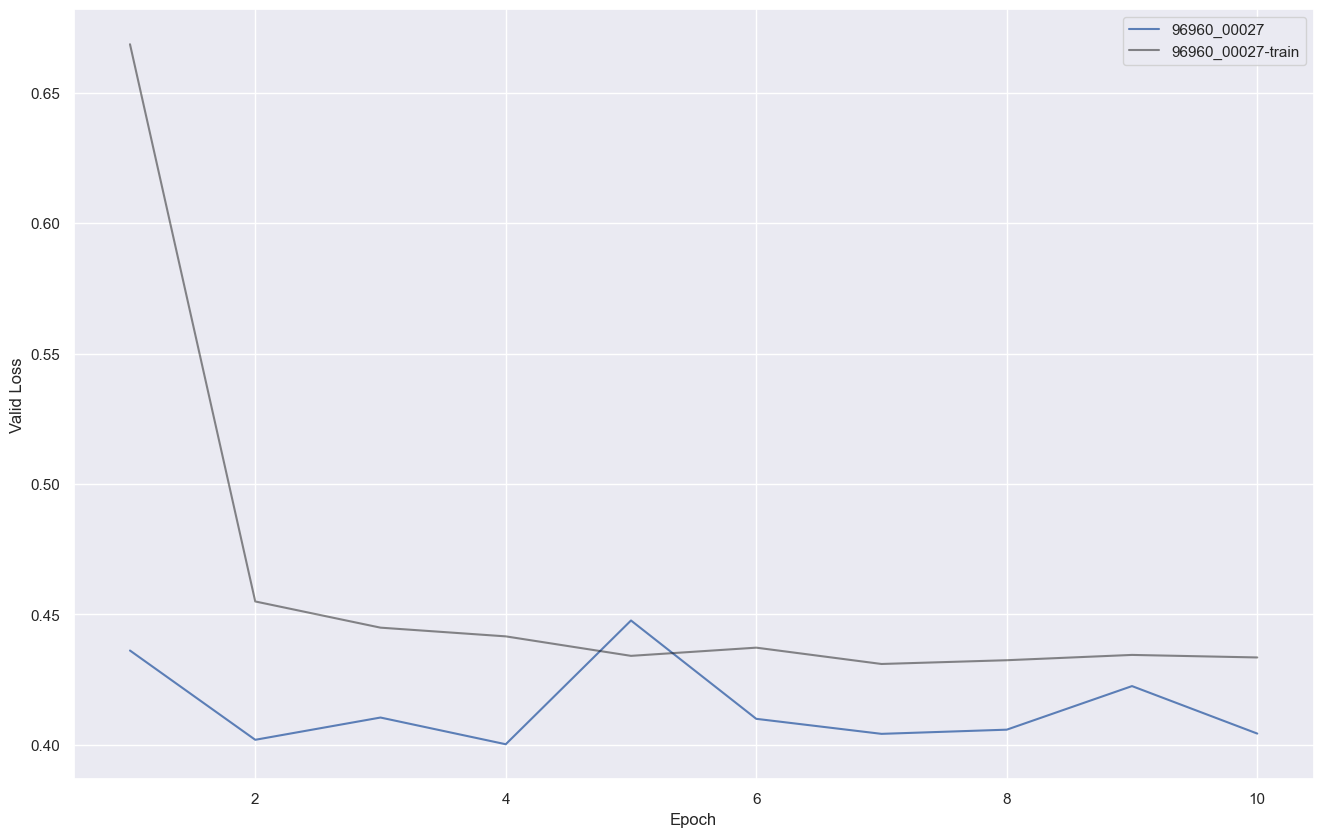

In [26]:
# Plot best trial valid loss

raytune_plot.trial_lineplot_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

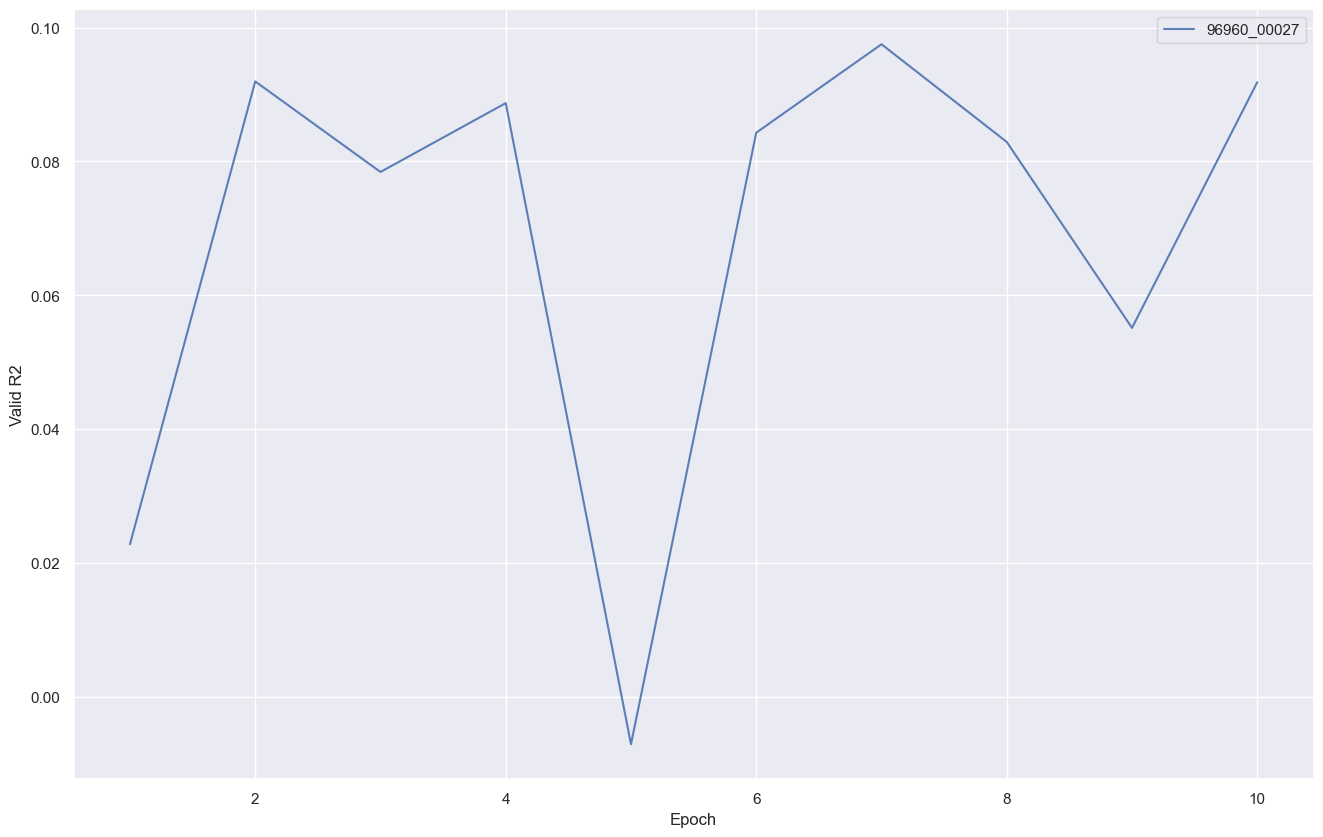

In [27]:
# Plot best trial valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trial_lineplot_r2(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

In [28]:
# Plot best trial valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trial_lineplot_accuracy(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

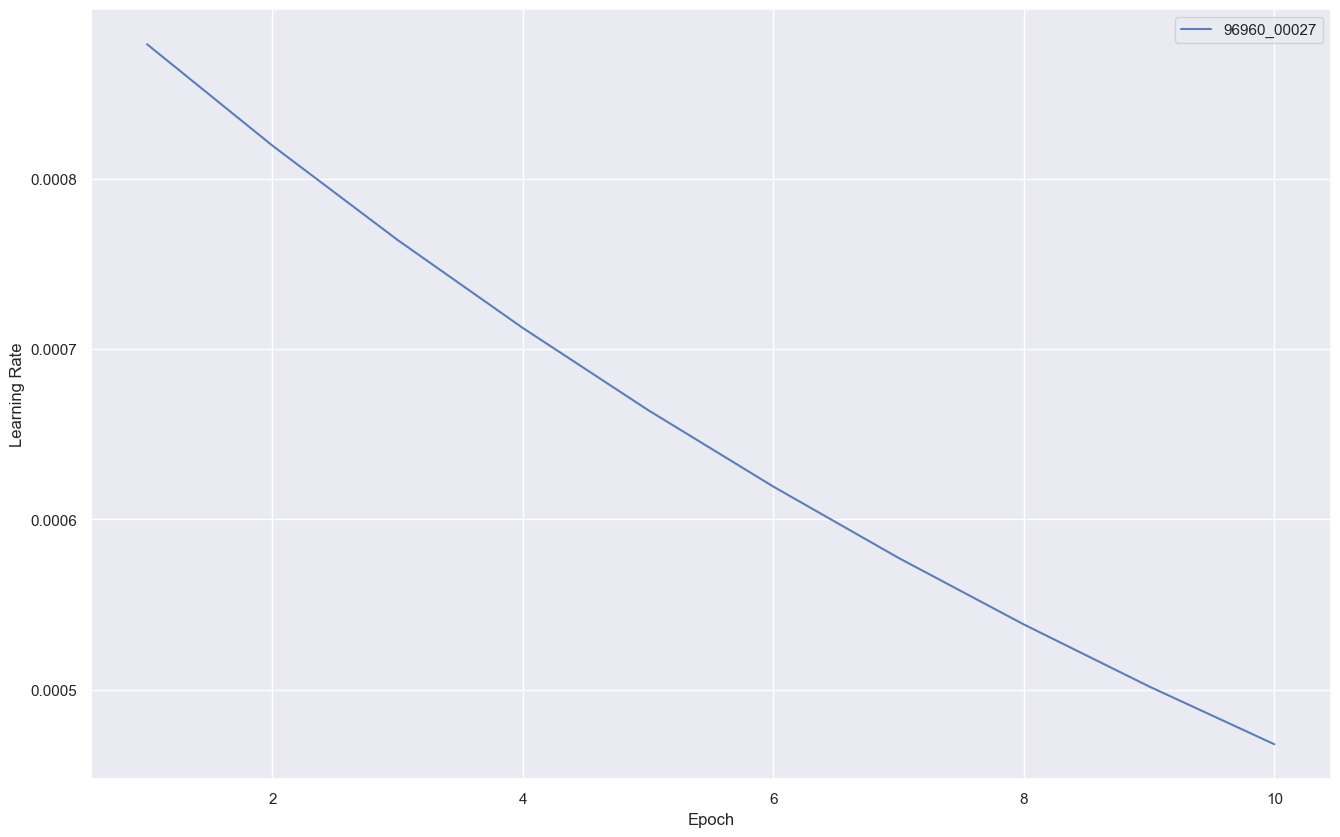

In [29]:
# Plot trials learning rate

raytune_plot.trial_lineplot_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)